# Install Libraries 

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import time
from moviepy.editor import VideoFileClip

# Test Images

In [2]:
image_dir = "data/input_images/test_image/"
image_list = os.listdir(image_dir)
image_list

['000008.jpg',
 '000028.jpg',
 '000116.jpg',
 '000040.jpg',
 '000066.jpg',
 '000164.jpg']

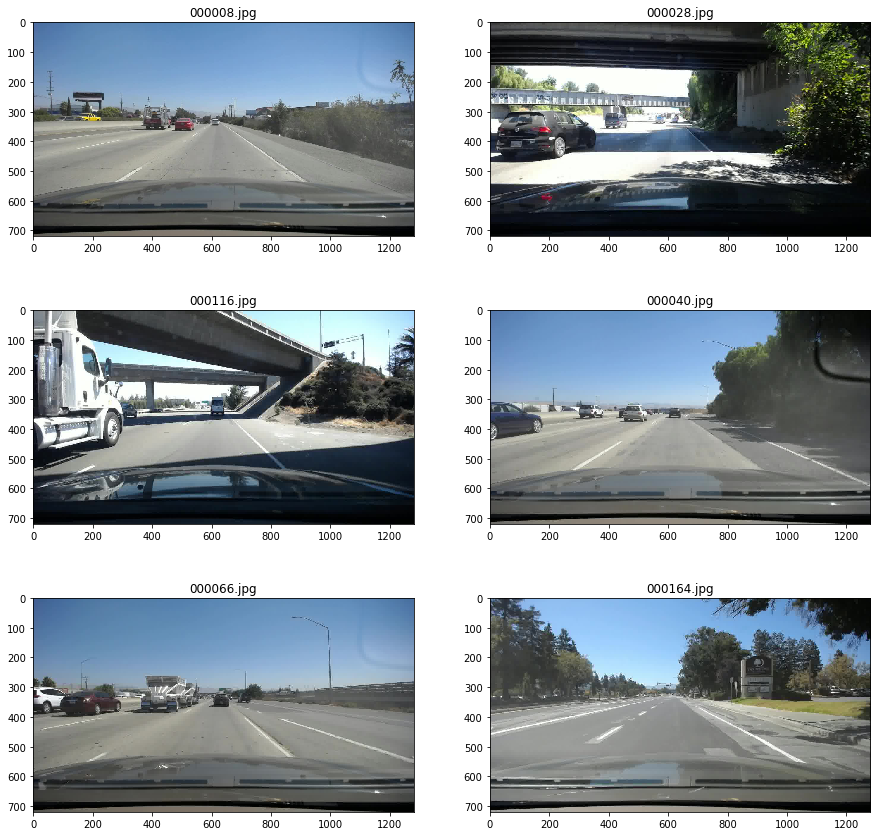

In [3]:
def show_image(i, image, cmap=None):
    if i == 0:
        fig=plt.figure(figsize=(15,15))
    plt.subplot(3, 2, i+1)
    plt.title(image_list[i])
    plt.imshow(image, cmap=cmap)

for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    show_image(i, image)

# Multi Threshold

In [4]:
def multi_threshold(image):
    settings = []
    settings.append({'cspace': 'LAB', 'channel': 2, 'clipLimit': 2.0, 'threshold': 150})
    settings.append({'cspace': 'HLS', 'channel': 1, 'clipLimit': 1.0, 'threshold': 220})
    settings.append({'cspace': 'HSV', 'channel': 2, 'clipLimit': 3.0, 'threshold': 230})

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    combined_binary = np.zeros_like(gray)
    for s in settings:
        color_t = getattr(cv2, 'COLOR_RGB2{}'.format(s['cspace']))
        gray = cv2.cvtColor(image, color_t)[:,:,s['channel']]
        
        clahe = cv2.createCLAHE(s['clipLimit'], tileGridSize=(8,8))
        norm_img = clahe.apply(gray)
        
        binary = np.zeros_like(norm_img)
        binary[(norm_img >= s['threshold']) & (norm_img <= 255)] = 1
        combined_binary[(combined_binary == 1) | (binary == 1)] = 1
    
    return combined_binary

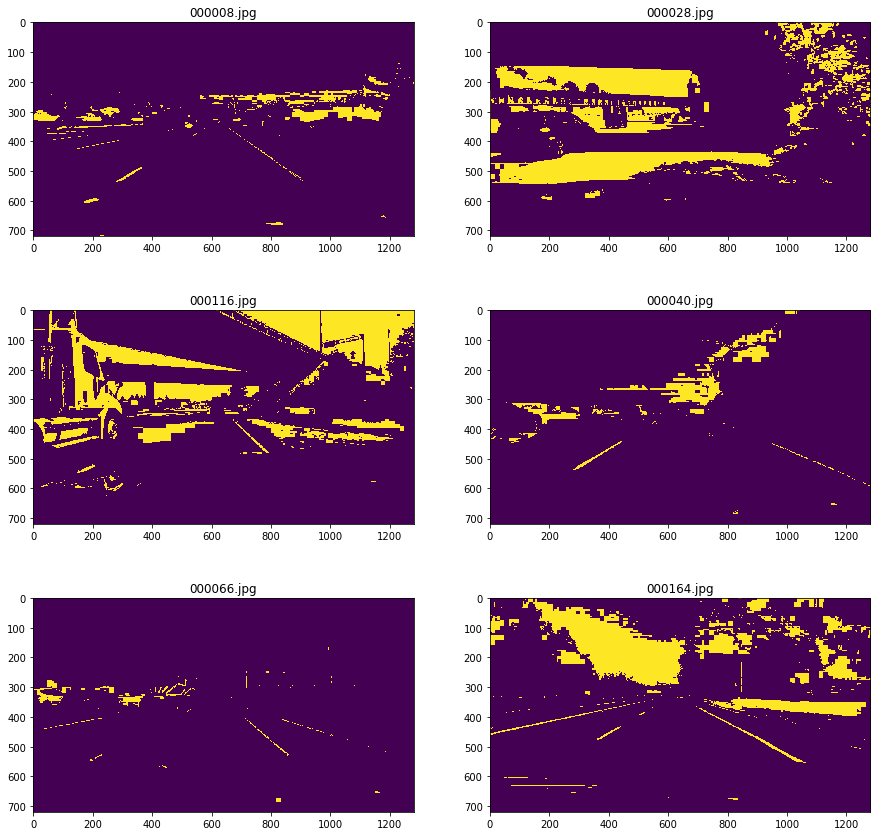

In [5]:
for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    
    image_threshold = multi_threshold(image)

    show_image(i, image_threshold)

# Mask Image

In [6]:
def mask_image(image_threshold, top=350, down=600):
    image_masked = image_threshold.copy()*0
    image_masked[top:down,:] = image_threshold[top:down,:]
    return image_masked

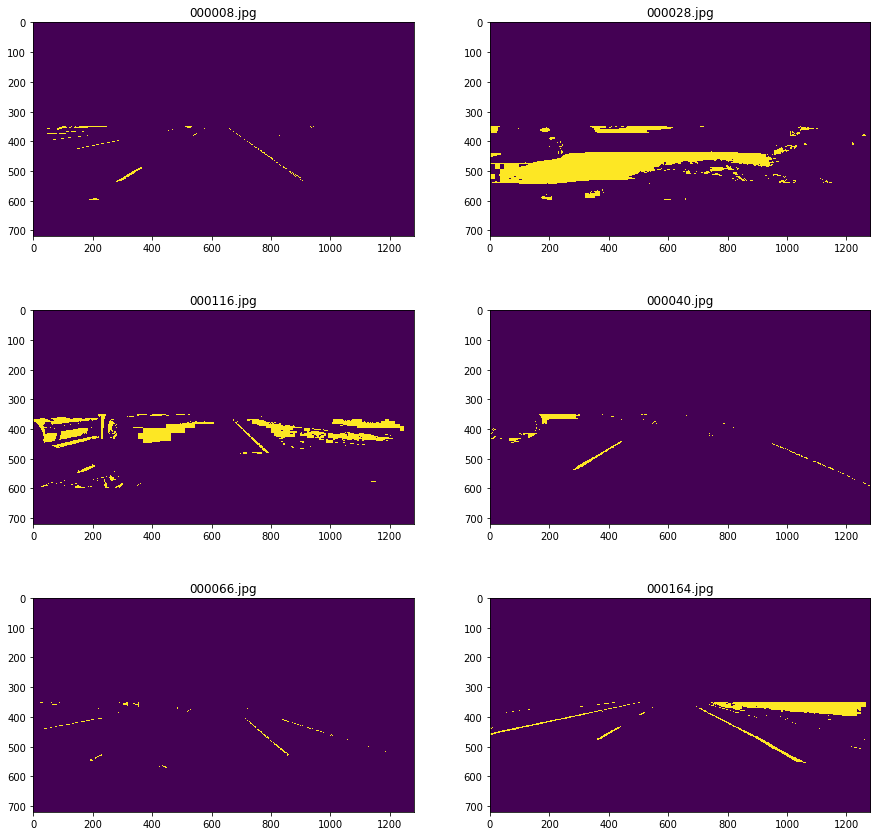

In [7]:
for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])

    image_threshold = multi_threshold(image)

    image_masked = mask_image(image_threshold)

    show_image(i, image_masked)

# Combine

In [8]:
def lane_detection(image):
    # filter
    image_thr = multi_threshold(image)
    
    # mask
    image_thr_mid = mask_image(image_thr)
    
    # prepare rgb
    image_thr_mid_w = np.dstack((image_thr_mid*255, image_thr_mid*255, image_thr_mid*255))
    image_thr_mid_r = np.dstack((image_thr_mid*255, image_thr_mid*0, image_thr_mid*0))
    
    # combine    
    image_thr_mid_w = cv2.bitwise_not(image_thr_mid_w)
    image_and = cv2.bitwise_and(image, image_thr_mid_w)
    image_final = cv2.addWeighted(image_and, 1.0, image_thr_mid_r, 1.0, 0)
    
    return image_final

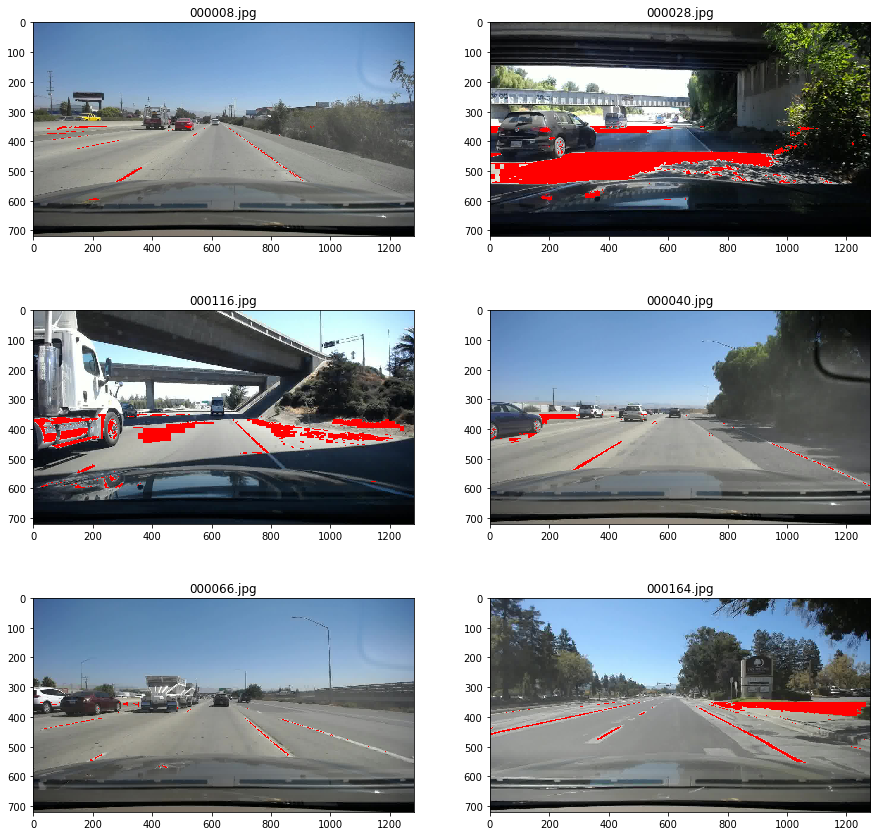

In [9]:
for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])    
    image_final = lane_detection(image)
    show_image(i, image_final)

# Processing Video

In [10]:
# input_path = 'data/input_videos/20180910_124456_input_freeway.mp4'

# start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
# output_path = 'data/output_videos/01_{:s}_freeway.mp4'.format(str(start_time))

In [14]:
input_path = 'data/input_videos/20180914_015504_input_night.mp4'

start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
output_path = 'data/output_videos/01_{:s}_night.mp4'.format(str(start_time))

In [15]:
clip1 = VideoFileClip(input_path)
white_clip = clip1.fl_image(lambda x: lane_detection(x))
%time white_clip.write_videofile(output_path, audio=True)

t:   0%|          | 7/7425 [00:00<01:54, 64.82it/s, now=None]

Moviepy - Building video data/output_videos/01_2019-03-26-18-48-55_night.mp4.
Moviepy - Writing video data/output_videos/01_2019-03-26-18-48-55_night.mp4



Moviepy - Done !
Moviepy - video ready data/output_videos/01_2019-03-26-18-48-55_night.mp4
CPU times: user 15min, sys: 2min 52s, total: 17min 52s
Wall time: 2min 47s
